In [42]:
import csv
import numpy as np
from collections import defaultdict
from matplotlib import pyplot
import pandas

In [43]:
BLANKS=["","RBNF1", "RBNF2", "RBNF", "0", "RBNF 1", "RBNF 2"]
#TOTAL= 5048
TOTAL=2734
#TOTAL=1351
#TOTAL=1201
#TOTAL=1168


In [44]:
def loadCsvData(fileName):
	matrix = []
	# open a file
	with open(fileName) as f:
		reader = csv.reader(f)
        # loop over each row in the file
		for row in reader:

			# cast each value to a float
			doubleRow = []
			for value in row:
				doubleRow.append(value.strip())

			# store the row into our matrix
			matrix.append(doubleRow)
	return matrix

In [45]:
def printData(matrix):
	for row in matrix:
		print (row)

In [56]:
data= loadCsvData("data/metadata.csv")

In [57]:
data=pandas.DataFrame(data[1:], columns=data[0])

In [58]:
interviewtxt =loadCsvData("data/interview text fille to ids.csv")

In [49]:
interviewtxt=pandas.DataFrame(interviewtxt[1:], columns=interviewtxt[0])


In [50]:
text_to_ids={}
for i in range(len(interviewtxt)):
    name=interviewtxt.at[i, interviewtxt.columns[0]]
    name=name[:name.rfind('.')]
    name=name.replace('\'','_')
    text_to_ids[name]=interviewtxt["interviewee_ids"][i].split(';')

In [51]:
ids_to_years=defaultdict(lambda: defaultdict(lambda:"0"))
for i in range(len(interviewtxt)):
    date=interviewtxt["date_of_first_interview"][i]
    year=date[date.rfind('/')+1:]
    ids=interviewtxt["interviewee_ids"][i].split(';')
    no_transcript=interviewtxt["no_transcript"][i]
    for num in ids:
        ids_to_years[num]["year"]= str(year)
        if no_transcript=="TRUE" and ids_to_years[num]["included"]=="0":
            ids_to_years[num]["included"]=False
        else:
            ids_to_years[num]["included"]=True

In [52]:
database=defaultdict(lambda: defaultdict(lambda:0))
for i in range(len(data)):
    if ids_to_years[data.loc[i, "interviewee_id"]]["included"]==False:
        continue
    for atr in data.columns:
        if atr== "researcher_assumed_birth_decade":
            continue
        if atr== "researcher_assumed_race":
            continue
        value= data[atr][i]
        if value in BLANKS and atr=="\ufeffbirth_decade":
            value= data.loc[i, "researcher_assumed_birth_decade"]
        if value in BLANKS and atr=="identified_race":
            value= data.loc[i, "researcher_assumed_race"]
        if value in BLANKS and atr == "real_interviewee_birth_year":
            value= data.loc[i, "approximate_interviewee_birth_year"]
        database[data.loc[i, "interviewee_id"]][atr]=value
    database[data.loc[i, "interviewee_id"]]["interview_year"]=ids_to_years[data.loc[i, "interviewee_id"]]["year"]

In [54]:
for i in database:
    print(database[i]["collection_id"])

BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWOH
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP
BWSP


OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS; SOOH
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OSS
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB
OWDB


HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM
HM



In [12]:
dataformatted=defaultdict(lambda: defaultdict(lambda:0))
for i in database : 
    if database[i]["sex"]=="Male":
        continue
    for atr in database[i]:
        value= database[i][atr]
        if value not in BLANKS:
            dataformatted[atr][value]+=1
print(dataformatted["real_interviewee_birth_year"])
for cat in dataformatted:
    total=0
    for x in dataformatted[cat]:
        total+= dataformatted[cat][x]
    dataformatted[cat]["No Info"]= TOTAL-total
        

    
        

defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f84b296aea0>, {'1897': 14, '1893': 9, '1902': 14, '1890': 2, '1898': 10, '1915': 36, '1900': 9, '1901': 6, '1888': 2, '1896': 11, '1906': 13, '1904': 6, '1903': 12, '1895': 3, '1899': 7, '1912': 34, '1885': 4, '1935': 52, '1905': 12, '1892': 6, '1910': 15, '1907': 17, '1886': 1, '1884': 1, '1913': 37, '1916': 29, '1917': 29, '1874': 1, '1941': 43, '1938': 50, '1927': 41, '1929': 34, '1945': 63, '1953': 51, '1947': 75, '1933': 30, '1909': 8, '1931': 46, '1943': 67, '1923': 46, '1918': 28, '1944': 70, '1989': 3, '1924': 66, '1930': 42, '1937': 58, '1948': 66, '1966': 10, '1972': 9, '1942': 50, '1925': 62, '1921': 37, 'h': 1, '1946': 60, '1934': 37, '1954': 43, '1922': 59, '1911': 21, '1958': 30, '1891': 3, '1988': 2, '1940': 55, '1957': 38, '1959': 12, '1960': 25, '1952': 49, '1939': 48, '1919': 28, '1914': 28, '1928': 24, '1932': 40, '1950': 51, '1926': 47, '1964': 32, '1908': 13, '1968': 8, '1936': 61, '1962': 22, '1920': 39, '1951

In [13]:
unknown=[]
for x in database:
    if database[x]['current_or_most_recent_occupation'] in BLANKS and database[x]["sex"]!="Male":
        unknown.append(database[x]["interviewee_name"])


In [14]:
for table in dataformatted:
    for x,y in dataformatted[table].items():
        print("{}: {}".format(x,y))
        #print(x)
        #print(y)

1890: 64
1900: 109
1910: 285
1880: 12
1930: 466
1870: 2
1940: 603
1920: 454
1950: 394
1980: 40
1960: 182
1970: 65
1990: 8
1970-1980: 1
1950s: 1
1940s: 1
No Info: 47
Black or African American: 1199
White: 1335
Asian: 42
Hispanic/Latinx: 29
Other Race: 4
Two or More Races: 27
Indigenous American or Alaska Native: 67
No Info: 31
Married (except if separated): 965
Widowed: 246
Divorced: 153
Never married: 70
Separated: 3
Single: 52
Domestic Partner: 1
Common Law: 1
No Info: 1243
High school graduate: 204
Bachelor's degree: 632
Graduate or professional degree: 1161
Associate's degree: 36
Some college: 412
9th to 12th grade but no diploma: 114
Less than 9th grade: 41
No Info: 134
Female: 2715
No Info: 19
Abbott, Jessie: 1
Adair, Christia: 1
Adams, Frankie V.: 1
Adams, Kathleen Redding: 1
Albrier, Frances Mary: 1
Alexander, Margaret Walker: 1
Alexander, Sadie: 1
Barker, Elizabeth Cordozo: 1
Barnett, Etta Moten: 1
Boyd, Norma: 1
Cass, Melnea: 1
Chinn, May Edward: 1
Craft, Juanita Jewel: 1
Dick

Ladner, Joyce: 1
Ray, Adine: 1
Dellums, Leola "Roscoe": 1
Jarvis, Charlene: 1
Bundles, A'Lelia: 1
Pierre, Zina: 1
Hewitt, Vivian: 1
Nelson West, Bennetta: 1
Clanton, Erma: 1
Edelin, Ramona: 1
Seon, Yvonne: 1
Jackson, Alexine: 1
Groomes, Thelma: 1
Daley, Thelma: 1
Aiyetoro, Adjoa: 1
Jones, Doris: 1
DeCosta-Willis, Miriam: 1
Scruggs-Leftwich, Yvonne: 1
Ashmore-Hudson, Anne: 1
Hobson, Mellody: 1
McDowell, Helen: 1
Grant, Jacquelyn: 1
Williams, Jamye: 1
Malveaux, Antoinette: 1
Gray, Joan: 1
Hassan-Fletcher, Bernyce: 1
Lewis, Samella: 1
Peeples, Audrey: 1
Brady-Hampton, Nelvia: 1
Cruzat, Mildred: 1
Starks, Alisa: 1
Morris, Madeline: 1
Higgins, Ora: 1
Sanford, Adelaide: 1
Morales, Carol: 1
Williams-Skinner, Barbara: 1
Murphy, Camay: 1
Sales, Ruby: 1
Johnson, Sandra: 1
Reagon, Bernice: 1
Draper, Frances: 1
Mitchell, Nannette: 1
Brown, Alma: 1
Height, Dorothy: 1
Fry, Rita: 1
Rabb, Madeline: 1
White, Linda: 1
Brown, Dorothy: 1
McKenzie, Floretta: 1
Stewart, Roma: 1
Kearney, Janis: 1
Quarles, Ru

VEE553: 1
VEE554: 1
VEE555: 1
VEE556: 1
VEE557: 1
VEE558: 1
VEE559: 1
VEE560: 1
VEE561: 1
VEE562: 1
VEE563: 1
VEE564: 1
VEE565: 1
VEE566: 1
VEE567: 1
VEE568: 1
VEE569: 1
VEE570: 1
VEE571: 1
VEE572: 1
VEE573: 1
VEE574: 1
VEE575: 1
VEE576: 1
VEE577: 1
VEE578: 1
VEE579: 1
VEE580: 1
VEE581: 1
VEE582: 1
VEE583: 1
VEE584: 1
VEE585: 1
VEE586: 1
VEE587: 1
VEE588: 1
VEE589: 1
VEE590: 1
VEE591: 1
VEE592: 1
VEE593: 1
VEE594: 1
VEE595: 1
VEE596: 1
VEE597: 1
VEE598: 1
VEE599: 1
VEE600: 1
VEE601: 1
VEE602: 1
VEE603: 1
VEE604: 1
VEE605: 1
VEE606: 1
VEE607: 1
VEE608: 1
VEE609: 1
VEE611: 1
VEE612: 1
VEE613: 1
VEE614: 1
VEE615: 1
VEE616: 1
VEE617: 1
VEE618: 1
VEE619: 1
VEE620: 1
VEE621: 1
VEE622: 1
VEE623: 1
VEE624: 1
VEE625: 1
VEE626: 1
VEE627: 1
VEE628: 1
VEE629: 1
VEE630: 1
VEE631: 1
VEE632: 1
VEE633: 1
VEE634: 1
VEE635: 1
VEE636: 1
VEE637: 1
VEE638: 1
VEE639: 1
VEE640: 1
VEE641: 1
VEE642: 1
VEE643: 1
VEE644: 1
VEE645: 1
VEE646: 1
VEE647: 1
VEE648: 1
VEE649: 1
VEE650: 1
VEE651: 1
VEE652: 1
VEE653: 1


VEE3346: 1
VEE3350: 1
VEE3352: 1
VEE3354: 1
VEE3357: 1
VEE3358: 1
VEE3359: 1
VEE3360: 1
VEE3367: 1
VEE3371: 1
VEE3372: 1
VEE3373: 1
VEE3374: 1
VEE3375: 1
VEE3377: 1
VEE3380: 1
VEE3381: 1
VEE3382: 1
VEE3384: 1
VEE3394: 1
VEE3398: 1
VEE3400: 1
VEE3402: 1
VEE3404: 1
VEE3405: 1
VEE3406: 1
VEE3408: 1
VEE3409: 1
VEE3411: 1
VEE3414: 1
VEE3417: 1
VEE3424: 1
VEE3427: 1
VEE3429: 1
VEE3435: 1
VEE3437: 1
VEE3440: 1
VEE3442: 1
VEE3444: 1
VEE3446: 1
VEE3453: 1
VEE3455: 1
VEE3457: 1
VEE3458: 1
VEE3459: 1
VEE3460: 1
VEE3462: 1
VEE3463: 1
VEE3466: 1
VEE3468: 1
VEE3473: 1
VEE3474: 1
VEE3477: 1
VEE3481: 1
VEE3482: 1
VEE3488: 1
VEE3492: 1
VEE3494: 1
VEE3495: 1
VEE3502: 1
VEE3503: 1
VEE3511: 1
VEE3518: 1
VEE3522: 1
VEE3524: 1
VEE3529: 1
VEE3530: 1
VEE3532: 1
VEE3533: 1
VEE3534: 1
VEE3537: 1
VEE3541: 1
VEE3543: 1
VEE3544: 1
VEE3547: 1
VEE3548: 1
VEE3553: 1
VEE3555: 1
VEE3558: 1
VEE3562: 1
VEE3563: 1
VEE3571: 1
VEE3575: 1
VEE3577: 1
VEE3578: 1
VEE3580: 1
VEE3581: 1
VEE3582: 1
VEE3583: 1
VEE3586: 1
VEE3588: 1

Jewelry Shop Owner: 1
Professor and Associate Dean at Oklahoma State University: 1
Cattle Farmer: 1
Literacy Activist: 1
University Extension Home Economist: 6
County Director of Home Demonstration: 2
Adjunct Professor of Home Economics: 1
University Program Specialist of Family and Consumer Sciences: 1
Laboratory Technician: 1
Director of Public Programs at NYU; Filmmaker: 1
Teachers' Assistant: 1
Associate Vice President of Langston University: 1
International Public Relationist: 1
Familiy and Consumer Science Teacher: 1
Member of National Extension Association of Family and Consumer Sciences: 1
County Director of Home Economics Extension: 1
City Treasurer: 2
Government Secretary: 1
Home Economics Teacher: 1
Home Economics Instructor: 1
Dry Cleaner: 1
Lecturer; Professional Storyteller: 1
Author; Professional Storyteller: 1
City Librarian: 1
Government Researcher: 1
Resort Sales Associate: 1
Director of Dietics for Veteran Affairs: 1
Art Teacher: 1
Instructor at Technology School: 1


In [15]:
#def checkAProfile(data, race, sex, education, birthdecade, exact):
#    total=0
#    attr=[("identified_race", race), ("sex", sex), ("education", education), ("\ufeffbirth_decade", birthdecade)]
#    for i in data: 
#        if exact:
#            skip=False
#            for a in attr:
#                if data[i][a[0]] in BLANKS and a[1] != "":
#                    skip=True
#           if skip:
#                continue
#        skip=False   
#        for a in attr:
#            cat= data[i][a[0]]
#            if a[1] != "" and cat not in BLANKS and cat != a[1]:
#                skip=True
#        if skip:
#            continue
#        total+=1
#    return total
    
    

In [16]:
ids_to_info=defaultdict(lambda: defaultdict(lambda:0))
for ids in database:
    ids_to_info[ids]["birth_decade"]=database[ids]["\ufeffbirth_decade"]
    ids_to_info[ids]["education"]=database[ids]["education"]
    ids_to_info[ids]["collection"]=database[ids]["collection_id"]
    ids_to_info[ids]["sex"]=database[ids]["sex"]
    ids_to_info[ids]["race"]=database[ids]["identified_race"]
    ids_to_info[ids]["interview_year"]=database[ids]["interview_year"]
    ids_to_info[ids]["birth_year"]=database[ids]["real_interviewee_birth_year"]


In [17]:
myfile = open("data/everything_but_falsehits_and_needsreview.txt")
txt = myfile.read()
myfile.close()

files=[]
tokens=txt.split()
for i in tokens:
    num= i.find("Files\\\\")
    if not num==-1:
        if not i.find("_")==-1:
            files.append(i.strip())
names=set()
for i in files:
    i=i[i.find("\\\\",8)+2:-1]
    names.add(i.strip())


In [18]:
decades=[]
for i in range(1870, 2000, 10):
    decades.append(str(i))
decades.append("No Info")
total=[]
for i in decades:
    total.append(dataformatted["\ufeffbirth_decade"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["birth_decade"]]+=1
hits_formatted=[]
for i in decades:
    hits_formatted.append(hits[i])
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(decades)):
    percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
    #if not i==len(decades)-1:
    #    percentage_noNI.append(int(hits_formatted[i]/(total[i])*100))
#percentage_noNI.append(None)


2731


In [19]:
df_decades = pandas.DataFrame([total, hits_formatted, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage Within Category"],columns=decades)

In [20]:
display(df_decades)

,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,No Info
total corpus,2,12,64,109,285,454,466,603,394,182,65,40,8,47
in rape cluster,0,2,14,18,24,56,65,151,90,38,13,7,0,0
Percentage Within Category,0,16,21,16,8,12,13,25,22,20,20,17,0,0


Corpus Interviewees by Birth Decades and Percent of Interviewees by Birth Decade whose Interviews Include Rape Terms

Table: splits whole corpus by birth decade, displays how many in corpus born in that decade, how many in the rape cluster were born that decade, and what percentage of the people born in that decade are in the rape cluster

In [21]:
decades=[]
for i in range(1870, 2000, 10):
    decades.append(str(i))
decades.append("No Info")
total=[]
for i in decades:
    total.append(dataformatted["\ufeffbirth_decade"][i])
total_double=[]
for i in range(6):
    total_double.append(total[2*i]+total[2*i+1])
total_double.append(total[-2])
total_double.append(total[-1])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["birth_decade"]]+=1
hits_formatted=[]
for i in decades:
    hits_formatted.append(hits[i])
hits_double=[]
for i in range(6):
    hits_double.append(hits_formatted[2*i]+hits_formatted[2*i+1])
hits_double.append(hits_formatted[-2])
hits_double.append(hits_formatted[-1])
percentage_withNI=[]
for i in range(len(total_double)):
    percentage_withNI.append(int(hits_double[i]/total_double[i]*100))
    #if not i==len(decades)-1:
    #    percentage_noNI.append(int(hits_formatted[i]/(total[i])*100))
#percentage_noNI.append(None)
print(sum(total_double))

2731


In [22]:
df_decades = pandas.DataFrame([total_double, hits_double, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage Within Category"],columns=["1870-1889", "1890-1909", "1910-1929", "1930-1949", "1950-1969", "1970-1989", "1990-1999", "No Info"])

In [23]:
display(df_decades)

,1870-1889,1890-1909,1910-1929,1930-1949,1950-1969,1970-1989,1990-1999,No Info
total corpus,14,173,739,1069,576,105,8,47
in rape cluster,2,32,80,216,128,20,0,0
Percentage Within Category,14,18,10,20,22,19,0,0


Corpus Interviewees by Birth Scores and Percent of Interviewees by Birth Score whose Interviews Include Rape Terms

Table: splits whole corpus by birth score, displays how many in corpus born in that score, how many in the rape cluster were born that score, and what percentage of the people born in that score are in the rape cluster

In [24]:
race=[]
for i in dataformatted["identified_race"]:
    race.append(i)
race.remove("No Info")
race.sort()
race.append("No Info")
total=[]
for i in race:
    total.append(dataformatted["identified_race"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["race"]]+=1
hits_formatted=[]
for i in race:
    hits_formatted.append(hits[i])
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
for i in range(len(race)):
    percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
    #if not i==len(race)-1:
    #    percentage_noNI.append(int(hits_formatted[i]/(totalnum-total[-1])*100))
#percentage_noNI.append(None)

In [25]:
df_race = pandas.DataFrame([total, hits_formatted, percentage_withNI],index=["total corpus", "in rape cluster", "Percentage Within Category"], columns=race)

In [26]:
display(df_race)

,Asian,Black or African American,Hispanic/Latinx,Indigenous American or Alaska Native,Other Race,Two or More Races,White,No Info
total corpus,42,1199,29,67,4,27,1335,31
in rape cluster,14,270,6,5,1,6,177,0
Percentage Within Category,33,22,20,7,25,22,13,0


Corpus Interviewees by Race and Percent of Interviewees by Race whose Interviews Include Rape Terms

Table: splits whole corpus by race, displays how many in corpus of a given race, how many in the rape cluster were of a given race, and what percentage of the people of said race are in the rape cluster

In [27]:
education=["Less than 9th grade", "9th to 12th grade but no diploma", "High school graduate", "Some college", "Associate's degree", "Bachelor's degree", "Graduate or professional degree", "No Info"]
total=[]
for i in education:
    total.append(dataformatted["education"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["education"]]+=1
hits_formatted=[]
for i in education:
    hits_formatted.append(hits[i])
total_correct=[sum(total[0:3]), sum(total[3:6]), total[-2], total[-1]]
hits_formatted_correct=[sum(hits_formatted[0:3]), sum(hits_formatted[3:6]), hits_formatted[-2], hits_formatted[-1]]
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
for i in range(4):
    percentage_withNI.append(int(hits_formatted_correct[i]/total_correct[i]*100))
    #if not i==3:
    #    percentage_noNI.append((hits_formatted_correct[i]/(totalnum-total[-1])*100))
#percentage_noNI.append(None)

In [28]:
df_education = pandas.DataFrame([total_correct, hits_formatted_correct, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage Within Category"], columns=["up to 12th grade", "up to college degree", "graduate or professional degree", "no info"])

In [29]:
display(df_education)

,up to 12th grade,up to college degree,graduate or professional degree,no info
total corpus,359,1080,1161,134
in rape cluster,41,185,241,0
Percentage Within Category,11,17,20,0


Corpus Interviewees by Education and Percent of Interviewees by Education whose Interviews Include Rape Terms

Table: splits whole corpus by education, displays how many in corpus have a certain level of education, how many in that education level were born that decade, and what percentage of the people with that education level are in the rape cluster

In [30]:
years=[]
for i in range(1972, 2019, 1):
    years.append(str(i))
years.append("No Info")
total=[]
for i in years:
    total.append(dataformatted["interview_year"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["interview_year"]]+=1
hits_formatted=[]
for i in years:
    hits_formatted.append(hits[i])
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(years)):
    if total[i]==0:
        percentage_withNI.append(0)
    else:    
        percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
    #if not i==len(years)-1:
    #    percentage_noNI.append((hits_formatted[i]/(totalnum-total[-1])*100))
#percentage_noNI.append(None)

2732


In [31]:
df_interview_year = pandas.DataFrame([total, hits_formatted, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage of total"], columns=years)

In [32]:
pandas.options.display.max_columns = 10

In [33]:
display(df_interview_year)

,1972,1973,1974,1975,1976,...,2015,2016,2017,2018,No Info
total corpus,4,4,18,8,19,...,121,128,57,9,207
in rape cluster,1,0,4,2,9,...,10,13,12,5,0
Percentage of total,25,0,22,25,47,...,8,10,21,55,0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

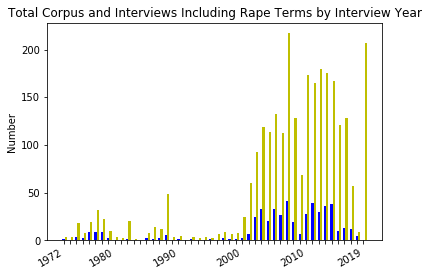

In [34]:
N = 48

ind = np.arange(N) 
values=[]
totals=[]

# some example data

values=hits_formatted
    
    
values = np.array(values)
total=np.array(total)


x = range(len(values))


# and plot it
fig, ax = pyplot.subplots()
hm=ax.bar(ind, values, 0.35, color="b")
total=ax.bar(ind+.35, total, .35, color="y")
ax.set_xticks(ind)
ax.set_xticklabels((1972,"","","","","","","",1980,"","","","","","","","","",1990,"","","","","","","","","",2000,"","","","","","","","","",2010,"","","","","","","","",2019))
ax.set_title('Total Corpus and Interviews Including Rape Terms by Interview Year')
ax.set_ylabel('Number')
pyplot.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')



In [35]:
years=[]
for i in range(1871, 1998):
    years.append(str(i))
years.append("No Info")
total=[]
for i in years:
    total.append(dataformatted["real_interviewee_birth_year"][i])
hits=defaultdict(lambda:0)
print(sum(total))
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["birth_year"]]+=1
hits_formatted=[]
for i in years:
    hits_formatted.append(hits[i])
percentage_withNI=[]
for i in range(len(years)):
    if total[i]==0:
        percentage_withNI.append(0)
    else:    
        percentage_withNI.append(int(hits_formatted[i]/total[i]*100))

2733


In [36]:
df_interview_year = pandas.DataFrame([total, hits_formatted, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage of total"], columns=years)

In [37]:
display(df_interview_year)

,1871,1872,1873,1874,1875,...,1994,1995,1996,1997,No Info
total corpus,1,0,0,1,0,...,1,1,1,1,51
in rape cluster,0,0,0,0,0,...,0,0,0,0,0
Percentage of total,0,0,0,0,0,...,0,0,0,0,0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

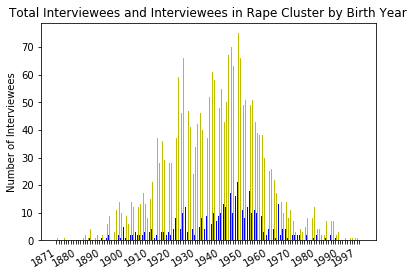

In [38]:
N = 128

ind = np.arange(N) 
values=[]
totals=[]

# some example data

values=hits_formatted
    
    
values = np.array(values)
total=np.array(total)


x = range(len(values))


# and plot it
space=["","","","","","","","",""]
fig, ax = pyplot.subplots()
hm=ax.bar(ind, values, 0.35, color="b")
total=ax.bar(ind+.35, total, .35, color="y")
ax.set_xticks(ind)
ax.set_xticklabels([1871,"","","","","","","","",1880]+space+[1890]+space+[1900]+space+[1910]+space+[1920]+space+[1930]+space+[1940]+space+[1950]+space+[1960]+space+[1970]+space+[1980]+space+[1990, "","","","","","",1997])
ax.set_title('Total Interviewees and Interviewees in Rape Cluster by Birth Year')
ax.set_ylabel('Number of Interviewees')
pyplot.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

By collection breakdowns

In [60]:
interviewtxt =loadCsvData("data/interview text fille to ids.csv")

In [61]:
interviewtxt=pandas.DataFrame(interviewtxt[1:], columns=interviewtxt[0])

In [92]:
file_to_ids={}
for i in range(len(interviewtxt)):
    filename=interviewtxt.at[i, interviewtxt.columns[0]]
    file_to_ids[filename]=interviewtxt["interviewee_ids"][i].split(';')
print(file_to_ids)

{'BWOH_Abbott_Jessie.txt': ['VEE0'], 'BWOH_Adair_Christia.txt': ['VEE1'], 'BWOH_Adams_Frankie.txt': ['VEE2'], 'BWOH_Adams_Kathleen.txt': ['VEE3'], 'BWOH_Albrier_Frances.txt': ['VEE4'], 'BWOH_Alexander_Margaret.txt': ['VEE5'], 'BWOH_Alexander_Sadie.txt': ['VEE6'], 'BWOH_Barker_Elizabeth.txt': ['VEE7'], 'BWOH_Barnett_Etta.txt': ['VEE8'], 'BWOH_Boyd_Norma.txt': ['VEE9'], 'BWOH_Cass_Melnea.txt': ['VEE10'], 'BWOH_Chinn_May.txt': ['VEE11'], 'BWOH_Craft_Juanita.txt': ['VEE12'], 'BWOH_Dickson_Clara.txt': ['VEE13'], 'BWOH_Dunnigan_Alice.txt': ['VEE14'], 'BWOH_Duster_Alfreda.txt': ['VEE15'], 'BWOH_Dykes_Eva.txt': ['VEE16'], 'BWOH_Eberhardt_Mae.txt': ['VEE17'], 'BWOH_Edmonds_Florence.txt': ['VEE18'], 'BWOH_Edwards_Lena.txt': ['VEE19'], 'BWOH_Ferebee_Dorothy.txt': ['VEE20'], 'BWOH_Fisher_Minnie.txt': ['VEE21'], 'BWOH_Flippin_Katherine.txt': ['VEE22'], 'BWOH_Gayton_Virginia.txt': ['VEE23'], 'BWOH_George_Zelma.txt': ['VEE24'], 'BWOH_Grant_Frances.txt': ['VEE25'], 'BWOH_Halyard_Ardie.txt': ['VEE26'],

In [73]:
ids_to_years=defaultdict(lambda: defaultdict(lambda:"0"))
for i in range(len(interviewtxt)):
    date=interviewtxt["date_of_first_interview"][i]
    year=date[date.rfind('/')+1:]
    ids=interviewtxt["interviewee_ids"][i].split(';')
    no_transcript=interviewtxt["no_transcript"][i]
    for num in ids:
        ids_to_years[num]["year"]= str(year)
        if no_transcript=="TRUE" and ids_to_years[num]["included"]=="0":
            ids_to_years[num]["included"]=False
        else:
            ids_to_years[num]["included"]=True

In [74]:
database=defaultdict(lambda: defaultdict(lambda:0))
for i in range(len(data)):
    if ids_to_years[data.loc[i, "interviewee_id"]]["included"]==False:
        continue
    for atr in data.columns:
        if atr== "researcher_assumed_birth_decade":
            continue
        if atr== "researcher_assumed_race":
            continue
        value= data[atr][i]
        if value in BLANKS and atr=="\ufeffbirth_decade":
            value= data.loc[i, "researcher_assumed_birth_decade"]
        if value in BLANKS and atr=="identified_race":
            value= data.loc[i, "researcher_assumed_race"]
        if value in BLANKS and atr == "real_interviewee_birth_year":
            value= data.loc[i, "approximate_interviewee_birth_year"]
        database[data.loc[i, "interviewee_id"]][atr]=value
    database[data.loc[i, "interviewee_id"]]["interview_year"]=ids_to_years[data.loc[i, "interviewee_id"]]["year"]

In [98]:
collection_database=defaultdict(lambda:0)
for i in range(len(interviewtxt)):
    if interviewtxt["no_transcript"][i]!="TRUE":
        file_name=interviewtxt["project_file_name"][i]
        women=False
        for x in file_to_ids[file_name]:
            x=x.strip()
            if database[x]["sex"]=="Female":
                women=True
        if women:
            collection_name=file_name[:file_name.find("_")]
            collection_database[collection_name]+=1
print(collection_database)

defaultdict(<function <lambda> at 0x7f84b3e3bae8>, {'BWOH': 70, 'BWSP': 162, 'ROHA': 86, 'SCAP': 195, 'SHSA': 30, 'SHSF': 49, 'SNAI': 9, 'RTRB': 137, 'UNCSW': 76, 'UNCGAS': 25, 'UNCTWMS': 151, 'SCAARJ': 14, 'SCAL': 15, 'SCVF': 51, 'OCFF': 48, 'ONA': 51, 'OOHYLC': 67, 'OSS': 167, 'OWDB': 46, 'OWHF': 37, 'SOOH': 182, 'WOL': 46, 'HM': 996})


In [102]:
collections=list(collection_database)
collections.sort()

In [103]:
total=[]
for i in collections:
    total.append(collection_database[i])

In [113]:
pandas.options.display.max_columns = 25

In [114]:
df_collections = pandas.DataFrame([total],columns=collections)

In [115]:
display(df_collections)

,BWOH,BWSP,HM,OCFF,ONA,OOHYLC,OSS,OWDB,OWHF,ROHA,RTRB,SCAARJ,SCAL,SCAP,SCVF,SHSA,SHSF,SNAI,SOOH,UNCGAS,UNCSW,UNCTWMS,WOL
0,70,162,996,48,51,67,167,46,37,86,137,14,15,195,51,30,49,9,182,25,76,151,46


In [118]:
myfile = open("data/everything_but_falsehits_and_needsreview.txt")
txt = myfile.read()
myfile.close()

files=[]
tokens=txt.split()
for i in tokens:
    num= i.find("Files\\\\")
    if not num==-1:
        if not i.find("_")==-1:
            files.append(i.strip())

['Files\\\\BWOH\\\\BWOH_Adair_Christia,', 'Files\\\\BWOH\\\\BWOH_Adair_Christia,', 'Files\\\\BWOH\\\\BWOH_Adair_Christia,', 'Files\\\\BWOH\\\\BWOH_Adams_Kathleen,', 'Files\\\\BWOH\\\\BWOH_Barnett_Etta,', 'Files\\\\BWOH\\\\BWOH_Duster_Alfreda,', 'Files\\\\BWOH\\\\BWOH_Edwards_Lena,', 'Files\\\\BWOH\\\\BWOH_Edwards_Lena,', 'Files\\\\BWOH\\\\BWOH_Harrison_Pleasant,', 'Files\\\\BWOH\\\\BWOH_Harrison_Pleasant,', 'Files\\\\BWOH\\\\BWOH_Harrison_Pleasant,', 'Files\\\\BWOH\\\\BWOH_Harrison_Pleasant,', 'Files\\\\BWOH\\\\BWOH_Harrison_Pleasant,', 'Files\\\\BWOH\\\\BWOH_Height_Dorothy,', 'Files\\\\BWOH\\\\BWOH_Height_Dorothy,', 'Files\\\\BWOH\\\\BWOH_Height_Dorothy,', 'Files\\\\BWOH\\\\BWOH_Jackson_Ellen,', 'Files\\\\BWOH\\\\BWOH_Kelly_Hattie,', 'Files\\\\BWOH\\\\BWOH_Kelly_Hattie,', 'Files\\\\BWOH\\\\BWOH_Kemp_Maida,', 'Files\\\\BWOH\\\\BWOH_Kittrell_Flemmie,', 'Files\\\\BWOH\\\\BWOH_Lancaster_Abna,', 'Files\\\\BWOH\\\\BWOH_Mitchell_Lucy,', 'Files\\\\BWOH\\\\BWOH_Moore_Audley,', 'Files\\\\BWOH\\

In [127]:
in_rape_cluster=defaultdict(lambda:0)
found=set()

In [128]:
for i in files:
    if i in found:
        continue
    found.add(i)
    in_rape_cluster[i[7:i.rfind("\\\\")]]+=1
print(hits)

defaultdict(<function <lambda> at 0x7f84b3c1fb70>, {'BWOH': 23, 'BWSP': 23, 'HM': 218, 'OOHYLC': 1, 'OSS': 2, 'OWHF': 4, 'ROHA': 12, 'RTRB': 24, 'SCAARJ': 6, 'SCAL': 7, 'SCAP': 10, 'SCVF': 36, 'SHSA': 3, 'SHSF': 11, 'SOOH': 3, 'UNCGAS': 7, 'UNCSW': 15, 'UNCTWMS': 64, 'WOL': 11})


In [212]:
totals=[]
for i in collections:
    totals.append(int(collection_database[i]))
hits=[]
for i in collections:
    hits.append(in_rape_cluster[i])
percentages_in_cluster=[]
percentages_of_total=[]
whole=sum(totals)
for i in collections:
    percentages_in_cluster.append(int(100*int(in_rape_cluster[i])/int(collection_database[i])))
    percentages_of_total.append(int(collection_database[i])*100//whole)

In [213]:
df_collections = pandas.DataFrame([totals, hits, percentages_of_total, percentages_in_cluster],columns=collections, index=["Number of Interviews", "Number of Interviews in rape cluster", "Percentage of whole corpus that this collection makes up", "Percentage of this collection in the rape cluster"])

In [214]:
display(df_collections)

,BWOH,BWSP,HM,OCFF,ONA,OOHYLC,OSS,OWDB,OWHF,ROHA,RTRB,SCAARJ,SCAL,SCAP,SCVF,SHSA,SHSF,SNAI,SOOH,UNCGAS,UNCSW,UNCTWMS,WOL
Number of Interviews,70,162,996,48,51,67,167,46,37,86,137,14,15,195,51,30,49,9,182,25,76,151,46
Number of Interviews in rape cluster,23,23,218,0,0,1,2,0,4,12,24,6,7,10,36,3,11,0,3,7,15,64,11
Percentage of whole corpus that this collection makes up,2,5,36,1,1,2,6,1,1,3,5,0,0,7,1,1,1,0,6,0,2,5,1
Percentage of this collection in the rape cluster,32,14,21,0,0,1,1,0,10,13,17,42,46,5,70,10,22,0,1,28,19,42,23


In [182]:
print(len(collections))

23


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

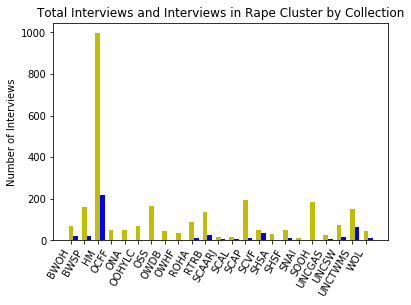

In [183]:
N = 23

ind = np.arange(N) 

# some example data
    
    
values = np.array(hits)
totals=np.array(totals)


x = range(len(values))


# and plot it
fig, ax = pyplot.subplots()
hm=ax.bar(ind, totals, 0.35, color="y")
total=ax.bar(ind+.35, values, .35, color="b")
ax.set_xticks(ind)
ax.set_xticklabels(collections)
ax.set_title('Total Interviews and Interviews in Rape Cluster by Collection')
ax.set_ylabel('Number of Interviews')
pyplot.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')

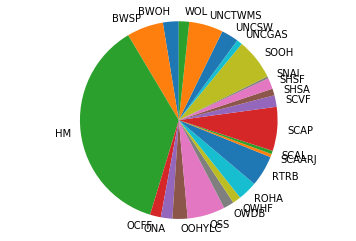

In [187]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = collections
sizes = totals
fig1, ax1 = pyplot.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

pyplot.show()

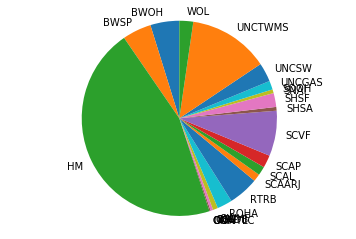

In [188]:
labels = collections
sizes = hits
fig1, ax1 = pyplot.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

pyplot.show()